C:\Users\Kha Nguyen\AppData\Local\Temp\ipykernel_6544\2856128238.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  stock_data[column] = stock_data[column].str.replace('$', '').astype(float)
C:\Users\Kha Nguyen\AppData\Local\Temp\ipykernel_6544\2856128238.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Close/Last'] = scaler.fit_transform(train_data[['Close/Last']])
C:\Users\Kha Nguyen\AppData\Local\Temp\ipykernel_6544\2856128238.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

Epoch 1/70
61/61 [==============================] - 6s 42ms/step - loss: 0.0134 - mean_absolute_error: 0.0670
Epoch 2/70
61/61 [==============================] - 3s 43ms/step - loss: 0.0024 - mean_absolute_error: 0.0305
Epoch 3/70
61/61 [==============================] - 3s 42ms/step - loss: 0.0017 - mean_absolute_error: 0.0251
Epoch 4/70
61/61 [==============================] - 3s 42ms/step - loss: 0.0019 - mean_absolute_error: 0.0266
Epoch 5/70
61/61 [==============================] - 3s 43ms/step - loss: 0.0017 - mean_absolute_error: 0.0263
Epoch 6/70
61/61 [==============================] - 3s 43ms/step - loss: 0.0016 - mean_absolute_error: 0.0241
Epoch 7/70
61/61 [==============================] - 3s 42ms/step - loss: 0.0018 - mean_absolute_error: 0.0260
Epoch 8/70
61/61 [==============================] - 3s 42ms/step - loss: 0.0015 - mean_absolute_error: 0.0233
Epoch 9/70
61/61 [==============================] - 3s 42ms/step - loss: 0.0013 - mean_absolute_error: 0.0222
Epoch 10/7

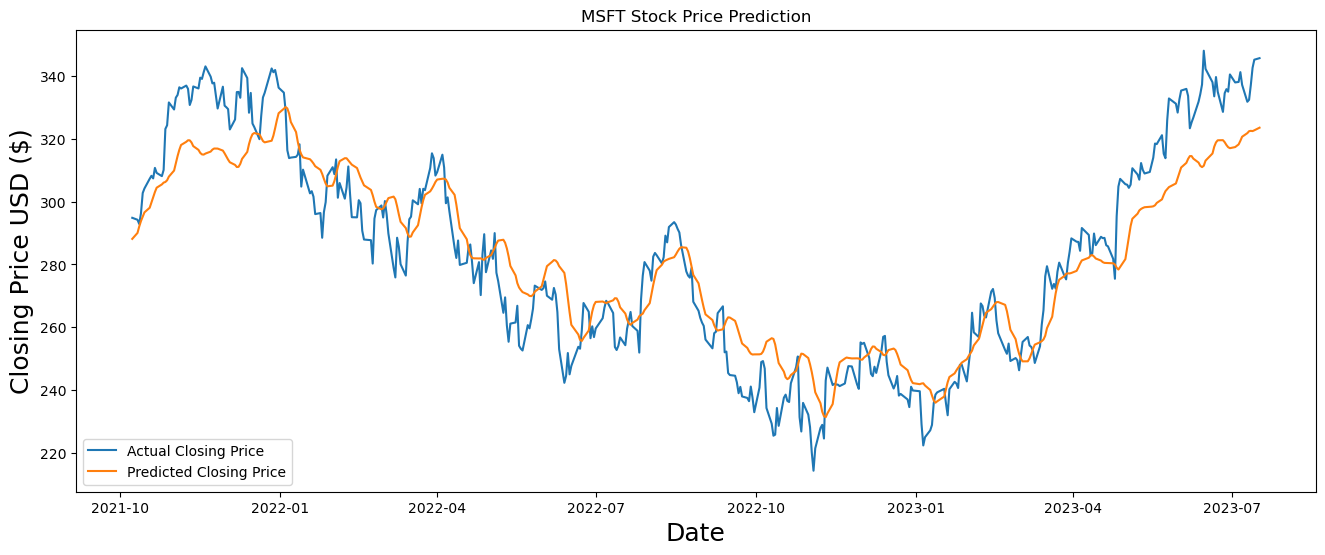

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout
import tensorflow as tf

# Read the csv file and clean the data
stock_data = pd.read_csv('../dataCleaning/data.csv')
stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce')
price_columns = ['Close/Last', 'Open', 'High', 'Low']
for column in price_columns:
    stock_data[column] = stock_data[column].str.replace('$', '').astype(float)
msft_data = stock_data[stock_data['Company'] == 'MSFT']
msft_data = msft_data.sort_values(by="Date")

# Time Series Splitting
train_size = int(0.8 * len(msft_data))
train_data = msft_data[:train_size]
test_data = msft_data[train_size:]

# Data Scaling
scaler = MinMaxScaler()
train_data['Close/Last'] = scaler.fit_transform(train_data[['Close/Last']])
test_data['Close/Last'] = scaler.transform(test_data[['Close/Last']])

# Sequence Creation
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data.iloc[i:i+sequence_length]['Close/Last'].values
        target = data.iloc[i+sequence_length]['Close/Last']
        sequences.append((sequence, target))
    return sequences

sequence_length = 60  
train_sequences = create_sequences(train_data, sequence_length)
test_sequences = create_sequences(test_data, sequence_length)

# Convert sequences to numpy arrays
X_train = np.array([seq[0] for seq in train_sequences])
y_train = np.array([seq[1] for seq in train_sequences])
X_test = np.array([seq[0] for seq in test_sequences])
y_test = np.array([seq[1] for seq in test_sequences])

# Model Building
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Model Compilation
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Model Training
model.fit(X_train, y_train, epochs=70, batch_size=32)

# Model Evaluation
train_loss = model.evaluate(X_train, y_train)
test_loss = model.evaluate(X_test, y_test)
print(f"Training Loss: {train_loss}")
print(f"Testing Loss: {test_loss}")

# Prediction
y_pred = model.predict(X_test)

# Inverse transform scaled predictions to get actual prices
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualization
plt.figure(figsize=(16, 6))
plt.title('MSFT Stock Price Prediction')
plt.plot(test_data['Date'].iloc[sequence_length:], y_test_actual, label='Actual Closing Price')
plt.plot(test_data['Date'].iloc[sequence_length:], y_pred_actual, label='Predicted Closing Price')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD ($)', fontsize=18)
plt.legend()
plt.show()


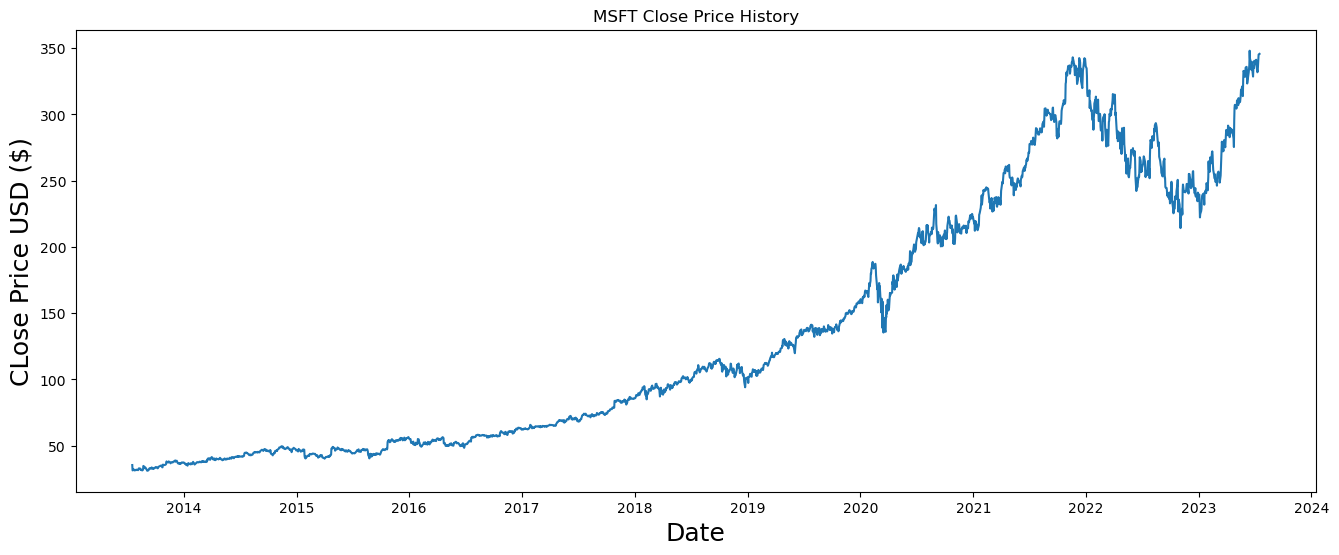

In [2]:
# Plotting the close price history (for the entire timeframe)
plt.figure(figsize=(16,6))
plt.title('MSFT Close Price History')
plt.plot(msft_data['Date'], msft_data['Close/Last'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('CLose Price USD ($)', fontsize=18)
plt.show()